# One Class SVM

### Step1: Dataset
     Upload ISIC 2019 and fitz patrick 17k datasets fo taining and testing and apply PCA visualization.

### Step2: apply grid search evalation to look for the best parameters

### Step 3: training and evalation
     Train the onesvm model after setting the parameters of the grid search.

In [ ]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import importlib
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Data preparation

In [ ]:

groundtruth = pd.read_csv("ISIC_2019_Training_GroundTruth.csv")
groundtruth = groundtruth.set_index("image")
indist = list(groundtruth.index)

X_data = []

folder_dir = "ISIC_2019_Training_Input"
images = Path(folder_dir).glob("*.jpg")
count = 0
for i in list(images)[:10000]:#10000
    image = Image.open(i).convert("RGB")
    img_resize = np.array(image.resize((32, 32), Image.Resampling.LANCZOS)).ravel()
    if i.stem in indist:
        X_data.append(img_resize)
        count += 1


In [ ]:
ood_darker = []
ood_lighter = []
ood_data = []
darker_dir = "fitzpatrick 17k /Darker_Skin_Tones"#ink to the dataset folders
lighter_dir = "fitzpatrick 17k /Lighter_Skin_Tones"
ALL_dir = "/fitzpatrick 17k /All images"

# Process images from the darker directory
darker_images = Path(darker_dir).glob("*.jpg")
for i in darker_images:
    image = Image.open(i).convert("RGB")
    img_resize = np.array(image.resize((32, 32), Image.Resampling.LANCZOS)).ravel()
    ood_darker.append(img_resize)
    ood_data.append(img_resize)

# Process images from the lighter directory
lighter_images = Path(lighter_dir).glob("*.jpg")
for i in list(lighter_images)[:3300]:#3300
    image = Image.open(i).convert("RGB")
    img_resize = np.array(image.resize((32, 32), Image.Resampling.LANCZOS)).ravel()
    ood_lighter.append(img_resize)
    ood_data.append(img_resize)

In [ ]:
ood_data = np.array(ood_data)
ood_lighter= np.array(ood_lighter)
ood_darker = np.array(ood_darker)

In [ ]:
len(X_data) , len(ood_data),len(ood_lighter) , len(ood_darker)

(10000, 4618, 3300, 1318)

In [ ]:
import numpy as np

X_array = np.array(X_data)
ood_array = np.array(ood_data)  #for all
ood_D_array = np.array(ood_darker) #for darker only
ood_L_array = np.array(ood_lighter) #for lighter only


In [ ]:
y_ind = np.zeros(X_array.shape[0])  # not an OOD sample
y_ood= np.ones(ood_array.shape[0]) *1 # an OOD sample
y_ood_D = np.ones(ood_D_array.shape[0]) * 2  # an OOD sample (darker)
y_ood_L = np.ones(ood_L_array.shape[0]) * 3  # an OOD sample (lighter)
X = np.concatenate([X_array, ood_D_array, ood_L_array])
y = np.concatenate([y_ind, y_ood_D, y_ood_L])
print(X.shape, y.shape)

(14618, 3072) (14618,)


## PCA visualization

explained variance ratio (first two components): [0.44557194 0.12567861]


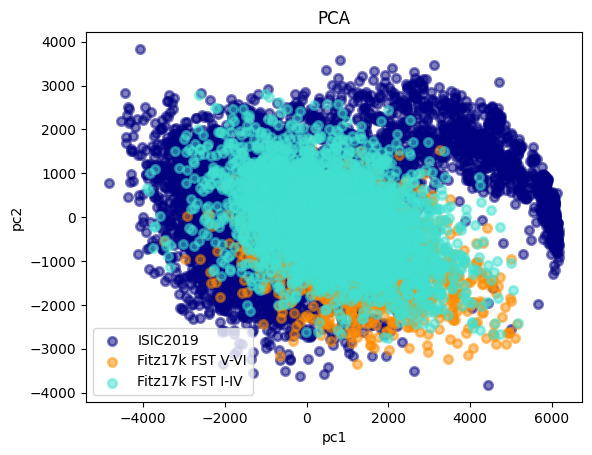

In [ ]:
import aux

importlib.reload(aux)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

aux.plot_pca(X_pca, y)

plt.show()

# Grid search

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, f1_score


X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.4, stratify=y, random_state=42)

outliers_fraction = 0.15
onesvm = OneClassSVM(kernel="rbf")
gamma  = 0.00001

# Define the parameter grid for OneClassSVM
param_grid = {

   'nu': [0.01,0.05, 0.1, 0.2]}

f1sc = make_scorer(f1_score, average='micro')

grid_estimator = GridSearchCV(onesvm, param_grid, scoring=f1sc, refit=True, cv=5, return_train_score=True, n_jobs=-1)
grid_estimator.fit(X_train, y_train)


best_params = grid_estimator.best_params_
best_f1_score = grid_estimator.best_score_
print("Best Parameters:", best_params)
print("Best F1 Score:", best_f1_score)



# Save the best parameters and best F1 score to a text file
with open('onesvm_grid_search_results.txt', 'w') as file:
    file.write(f"Best Parameters: {best_params}\n")
    file.write(f"Best F1 Score: {best_f1_score}\n")


Best Parameters: {'nu': 0.01}
Best F1 Score: 0.24548872180451128


# SVM model training

In [ ]:
from sklearn.svm import OneClassSVM
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.4, stratify=y, random_state=42)

onesvm = OneClassSVM(kernel="rbf", gamma=0.00001,nu=0.01)
onesvm.fit(X_train)

OneClassSVM(gamma=1e-05, nu=0.01)

In [ ]:
import pickle
with open('One_SVM_model','wb') as f:
    pickle.dump(onesvm,f)